<a href="https://colab.research.google.com/github/DhasiM/nutrition_by_numbers/blob/development/Final_Nutrition_By_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Goal and Description
The goal of the project was to create a database, build a regression model that uses informations from the database and create a dashboard to visualise important information.

# Data Cleaning

###Import Libraries

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [6]:
#!pip install mysql.connector

# Import the dataset
 
 From the database

In [7]:
#Iport mysql conncetor to load from local db
#import mysql.connector as sql
#db_connect=sql.connect(host='127.0.0.1', database='nutrition', user='root')

In [8]:
#data=pd.read_sql("SELECT * FROM zed", con=db_connect)

 ## Data Preprocessing 
 Preliminary data processing was done in PhpMyadmin. This includes, inspecting the column names, adding and deleting columns. 
 Here the data pre-processed for modelling puposes.

In [50]:
#Restructure the dataframe 
def restructure(df):
    columns = [x for x in df.columns[2:]] # create column to index columns
    df['year']= pd.Series(columns)
    
    f=pd.DataFrame()

    for idx , row in df.iterrows():
        #f=pd.DataFrame(columns=columns)
        f[f"{idx}"]=row
    del(df)
    
    #Rest index and add year as a column
    df=f.reset_index()
     
    #Changer header and drop first row
    #df.columns=df.iloc[0]
    df= df.iloc[1:, :]
# #check changes
    df.head(1)
    
    return df


In [62]:
#Could not connect to database in google colab and data was loaded from csv
data=pd.read_csv("/content/sample_data/Zed.csv")
data= data.iloc[1:-1, 2:]
train =restructure(data)
train.head()

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,1960,NaN,NaN,NaN,NaN,81714285.71,NaN,NaN,NaN,46.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1961,NaN,NaN,NaN,NaN,88857142.86,25.97,NaN,NaN,47.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.37,NaN
3,1962,NaN,NaN,NaN,NaN,85571428.57,26.04,NaN,NaN,47.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.23,NaN
4,1963,NaN,NaN,NaN,NaN,93571428.57,26.1,NaN,NaN,47.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.04,NaN
5,1964,NaN,NaN,NaN,NaN,100571428.6,26.18,NaN,NaN,48.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.87,NaN


In [64]:
#Create a date_time indes for use in Grafana
dates= [i for i in range(1960,2022)]
train['date_time']=pd.Series(dates)
train['date_time'] =  pd.to_datetime(train['date_time'])   
#rain = train.set_index('date_time')

In [65]:
#Select target variables, the columns were renamed 18 and 19 using the series column
train= train.iloc[:-2, :-1]
y = train.pop('16')
y.head()
y2= train.pop('17')
X=train

In [66]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
#convert datatype
X=X.fillna(0)
X=X.astype(float)
y=y.fillna(0)
y=y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
#train, test = train_test_split(train, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

#convert to tensors
X_train=tf.convert_to_tensor(X_train)
y_train=tf.convert_to_tensor(y_train)
X_test=tf.convert_to_tensor(X_test)
y_test=tf.convert_to_tensor(y_test)

(42, 17)
(19, 17)


In [67]:
#in case of unmatched strings
#X.columns.str.match("Unnamed")
#X.loc[:,~X.columns.str.match("Unnamed")]

# Model Training and Evaluation

In [68]:
# LOalibraries
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [70]:
# Define model
model = Sequential()
model.add(Dense(500, input_dim=17, activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary() #Print model Summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               9000      
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               50100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [77]:
import os
checkpoint_path = "content/logs.train/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),

]

In [89]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs=300, callbacks=my_callbacks)
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

Epoch 1/300
2/2 [==============================] - 1s 15ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2/300
2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/300
2/2 [==============================] - 0s 13ms/step - loss: 8.5861e-04 - mean_squared_error: 8.5861e-04
Epoch 4/300
2/2 [==============================] - 0s 14ms/step - loss: 6.9215e-04 - mean_squared_error: 6.9215e-04
Epoch 5/300
2/2 [==============================] - 0s 13ms/step - loss: 5.8618e-04 - mean_squared_error: 5.8618e-04
Epoch 6/300
2/2 [==============================] - 0s 11ms/step - loss: 3.9230e-04 - mean_squared_error: 3.9230e-04
Epoch 7/300
2/2 [==============================] - 0s 12ms/step - loss: 3.0528e-04 - mean_squared_error: 3.0528e-04
Epoch 8/300
2/2 [==============================] - 0s 17ms/step - loss: 2.0426e-04 - mean_squared_error: 2.0426e-04
Epoch 9/300
2/2 [==============================] - 0s 13ms/step - loss: 1.7248e-04 - mea

In [113]:
#from google.colab import files
#!zip -r ./my_model.zip /content/saved_model



In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

0.08306537568569183
0.08306537568569183


In [ ]:
new_model = tf.keras.models.load_model('/content/saved_model/my_model')
pred= new_model.predict(X_test)
pred

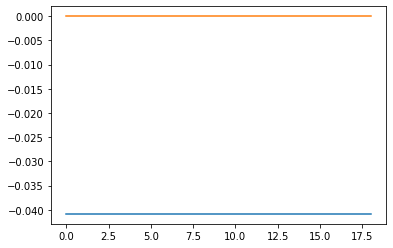

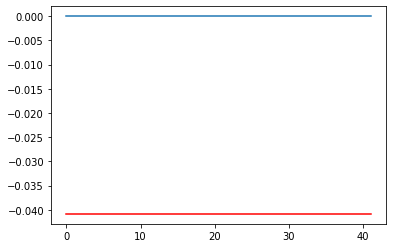

In [76]:
import matplotlib.pyplot as plt
plt.plot(pred)
plt.plot(y_test)
plt.show()
plt.plot(pred_train, color='red')
plt.plot(y_train)
plt.show()

## Write predictions to database